# Optimizing Pose Estimation pipeline with 🤗 Transformers

To build an optimized Pose Estimation pipeline, we will use the **ViTPose** model from Hugging Face Transformers.

ViTPose is a **top-down pose estimation model**, meaning it operates on cropped object regions. This requires an **object detection model** to first identify humans in an image. Thanks to Transformers, we have several strong candidates, and for real-time performance, we will use **RT-DETR**, a fast object detector designed for real-time inference.

### Our Pose Estimation Pipeline:
1. **Load Image / Video Frame**
2. **Object Detection Step**  
   - Preprocess input (resize, normalize, etc.)  
   - Run forward pass to obtain detector outputs  
   - Post-process results to extract bounding boxes of humans  
3. **Pose Estimation Step**  
   - Crop detected bounding boxes, resize, and normalize  
   - Run keypoint detection using **ViTPose**  
   - Post-process model outputs to extract keypoint coordinates  
4. **[Optional] Visualize Results / Do Analytics**  

Our target runtime is real-time performance. Steps 1 (Object Detection) and 2 (Pose Estimation) together should take no longer than 1000ms / 24fps ≈ 40ms to maintain 24 FPS. However, since additional operations like image loading, visualization, and analytics also take time, we will set a more ambitious goal of 25ms total for these two steps.

Of course, performance heavily depends on the hardware and software running the pipeline. In this tutorial, we will use the following setup:

 - GPU: NVIDIA L4 (8.9 CUDA capability)
 - PyTorch: 2.5.1+cu124
 - Transformers: 4.48.1

In [1]:
# Run the cell to get you env setup
# !transformers-cli env

## Preparation step

Let's ensure we import all required modules, define `device` and load an image to experiment with

In [2]:
import torch
import requests
import numpy as np
import torchvision

from PIL import Image
from typing import Tuple

from transformers import AutoProcessor
from transformers import RTDetrForObjectDetection, VitPoseForPoseEstimation

/home/ubuntu/projects/transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


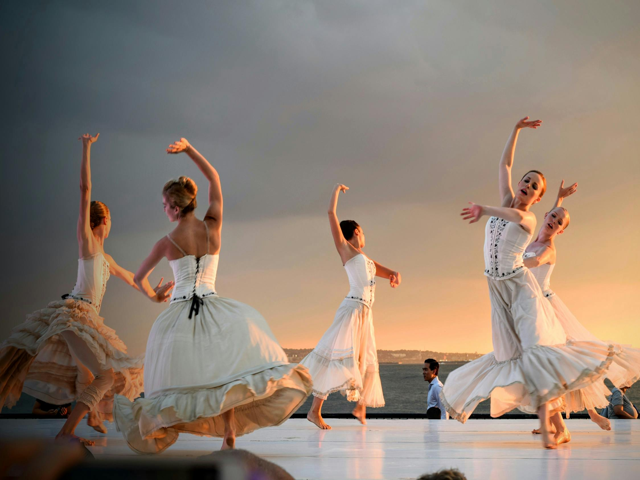

In [4]:
# Let's also load an example image
url = "https://images.pexels.com/photos/175658/pexels-photo-175658.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"
pil_image = Image.open(requests.get(url, stream=True).raw)
image = np.array(pil_image)

pil_image.resize([640, 480])

# Build and benchmark initial pipeline

In [5]:
# Object detection model
detector_checkpoint = "PekingU/rtdetr_r34vd"
detector = RTDetrForObjectDetection.from_pretrained(detector_checkpoint, device_map=device)
detector_image_processor = AutoProcessor.from_pretrained(detector_checkpoint)

# Pose estimation model
pose_checkpoint = "usyd-community/vitpose-plus-small"
pose_model = VitPoseForPoseEstimation.from_pretrained(pose_checkpoint, device_map=device)
pose_image_processor = AutoProcessor.from_pretrained(pose_checkpoint) # fast is not yet implemented

/home/ubuntu/projects/transformers/.venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
%%timeit

# ----------------------------
# Step 1. Object detection
# ----------------------------

# Preprocess image
detector_inputs = detector_image_processor(images=image, return_tensors="pt").to(device)

# Run detection
with torch.no_grad():
    detection_outputs = detector(**detector_inputs)

# Postprocess detection
height, width = image.shape[:2]
detection_results = detector_image_processor.post_process_object_detection(
    detection_outputs, target_sizes=[(height, width)], threshold=0.3
)
image_detections = detection_results[0]  # take first image results

# Get human boxes (label 0 in COCO dataset)
person_boxes_xyxy = image_detections["boxes"][image_detections["labels"] == 0]
person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()

# Convert boxes to format for pose estimation
person_boxes_xywh = person_boxes_xyxy.copy()
person_boxes_xywh[:, 2] = person_boxes_xyxy[:, 2] - person_boxes_xyxy[:, 0]
person_boxes_xywh[:, 3] = person_boxes_xyxy[:, 3] - person_boxes_xyxy[:, 1]

# ----------------------------
# Step 2. Pose estimation
# ----------------------------

pose_inputs = pose_image_processor(image, boxes=[person_boxes_xywh], return_tensors="pt").to(device)

# Required for ViTPose++ models, this architecture uses MoE layers.
# We specify which "Expert" to use for each image in batch.
batch_size = person_boxes_xyxy.shape[0]
pose_inputs["dataset_index"] = torch.full((batch_size,), 0, dtype=torch.int64, device=device)

with torch.no_grad():
    pose_outputs = pose_model(**pose_inputs)

pose_results = pose_image_processor.post_process_pose_estimation(pose_outputs, boxes=[person_boxes_xywh])

torch.cuda.synchronize()

117 ms ± 455 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


I ran the pipeline and obtained the following results:  

- **117 ms ± 455 μs per loop** (mean ± std. dev. of **7 runs, 10 loops each**)  

(*You can uncomment `%%timeit` at the top of the previous cell to benchmark execution time.*)  

**117 ms** is still far from real-time, but it allows us to run at approximately **9 FPS**. To improve performance, it’s crucial to break down the execution time for each individual sub-step and identify where the biggest bottlenecks are.  

You can experiment with the next cell, copy and paste parts of the code above and benchmark different sections to analyze performance.  

In [10]:
%%timeit
# --- Paste your code here ---

detector_inputs = detector_image_processor(images=image, return_tensors="pt").to(device)

# --- End of paste ---
torch.cuda.synchronize()

Here are the results for all sub-steps:

| Step     | Time, ms |
| -------- | -------- |
| Detector preprocessing | 19.2 |
| Detector forward | 18.6 |
| Detector postprocessing | 0.6 |
| Pose estimation preprocessing | 49.3 |
| Pose estimation forward | 20.7 |
| Pose estimation postprocessing | 11 |

How we can optimize the steps above?

To speedup models forward:
1) [Easy] Use lower precision, instead of default float32 we can use float16/bfloat16
2) [Easy] Compile models with `torch.compile`

To speedup detector pre/post-processing:
1) [Easy] Use `Fast` image processor from Transformers

To Speedup pose estimation pre/post-processing:
1) [Middle] We don't yet have `Fast` image processor for VitPose, however this step takes a ton of time, so we are going to rewrite it to get significant speedup!

Let's start!

## Stage 1. Optimizing object detection model

In [11]:
dtype = torch.bfloat16 if torch.cuda.get_device_capability() > (8, 0) else torch.float16
print(f"Using dtype: {dtype}")

Using dtype: torch.bfloat16


In [12]:
# Load model in specified precision, e.g. specify `torch_dtype=torch.bfloat16`
detector = RTDetrForObjectDetection.from_pretrained(detector_checkpoint, device_map=device, torch_dtype=dtype)

# Use fast, torch-based image processor, just provide `use_fast=True`
detector_image_processor = AutoProcessor.from_pretrained(detector_checkpoint, use_fast=True)

#### Preprocessing

Applying `Fast` image processor: 19.2 ms -> 1.16 ms

In [14]:
# %%timeit
detector_inputs = detector_image_processor(images=image, device=device,return_tensors="pt")
detector_inputs = detector_inputs.to(dtype)

1.16 ms ± 1.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Forward pass

Applying lower precision and compilation: 18.6 ms -> 4.3 ms

In [15]:
# Apply compilation and warmup for model
compiled_detector = torch.compile(detector, fullgraph=True, mode="reduce-overhead")

# Compilation happens in the first forward pass, so we need to warmup the model
for _ in range(10):
    with torch.no_grad():
        compiled_detector(**detector_inputs)

In [17]:
# %%timeit
with torch.no_grad():
    outputs = compiled_detector(**detector_inputs)

torch.cuda.synchronize()

4.26 ms ± 46.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Postprocessing

Applying `Fast` image processor for postprocessing: 0.6 ms -> 0.6 ms (nothing changed, but it's already fast)

In [19]:
# %%timeit
height, width = image.shape[:2]
results = detector_image_processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes_xyxy = result["boxes"][result["labels"] == 0]

644 μs ± 48.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


To summarize, after applying those easy steps we got:
| Step     | Time (raw), ms | Time (optimized), ms |
| -------- | -------- | -------- |
| Detector preprocessing | 19.2 | 1.16 |
| Detector forward | 18.6 | 4.3 |
| Detector postprocessing | 0.6 | 0.6 |
| Whole detection step | 38.4 | 6.06 |

Super nice!! We reduced time from 38.4 ms to 6.06 ms, it's 6.3 times faster!  

Let's continue with pose estimation step!

## Stage 2. Optimizing keypoints detection step

In [20]:
# Load model in specified precision, e.g. specify `torch_dtype=torch.bfloat16`
pose_model = VitPoseForPoseEstimation.from_pretrained(pose_checkpoint, device_map=device, torch_dtype=dtype)

#### Preprocessing

As mentioned at the beginning, **ViTPose does not yet have a fast image processor implemented**. The image processor in **Hugging Face Transformers** fully reproduces the original preprocessing steps which are hard to optimize for speed keeping 100% reproducibility. Specifically, the original preprocessing consists of:  

- **Preprocessing bounding boxes**: Expanding them to capture some area around the object while maintaining a **4:3 aspect ratio** (crop height = 256, crop width = 192).  
- **Applying an affine transformation**, which is equivalent to cropping the box and resizing it to the specified size.  
- **Rescaling pixel values** from **0–255 to 0–1** and normalizing using `mean` and `std`.  

While **box preprocessing** and **rescale normalization** are straightforward to optimize, the key bottleneck is **object extraction**. This operation scales **linearly** with the number of detected objects since we must iterate over each bounding box to extract it from the image.  

I experimented with several approaches, and the **fastest one** I found was using **`roi_align` from `torchvision`**. This operation, commonly used in **two-stage object detectors**, does exactly what we need - it extracts a region specified by a bounding box and resizes it to a fixed size. While it's not **100% identical** to the original method, the results are very similar (the region is the same, but pixel values vary a bit), and **ViTPose is robust enough** to handle this approximation.  

Below is the **optimized preprocessing function**. Thanks to **GPU parallelization**, the region extraction time remains **constant**, regardless of the number of detected bounding boxes. I observed a **consistent ~10ms** processing time, whether handling **1 bounding box or 20**.  

In [21]:
def preprocess_boxes(boxes_xyxy: torch.Tensor, crop_height=256, crop_width=192, padding_factor=1.25):
    """
    First, align box aspect ratio with respect to the maximum crop dimension,
    then expand it by padding factor.
    """
    # We will expand box to preserve aspect ratio
    # of desired crop size
    aspect_ratio = crop_width / crop_height
    x_min, y_min, x_max, y_max = boxes_xyxy.T

    # Get center coords and width/height
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    # Align with respect to aspect ratio
    height = torch.where(width > height * aspect_ratio, width * 1 / aspect_ratio, height)
    width = torch.where(width < height * aspect_ratio, height * aspect_ratio, width)

    # Expand by padding factor
    height = height * padding_factor
    width = width * padding_factor

    # Get new coords
    x_min = x_center - width / 2
    y_min = y_center - height / 2

    return torch.stack([x_min, y_min, x_min + width, y_min + height], dim=1)

def preprocess_image(
    image: np.ndarray,
    boxes_xyxy: torch.Tensor,
    mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
    std: Tuple[float, ...] = (0.229, 0.224, 0.225),
    crop_height: int = 256,
    crop_width: int = 192,
    dtype: torch.dtype = torch.float32,
    device: torch.device = torch.device("cpu"),
):
    # preprocess boxes
    boxes_xyxy = preprocess_boxes(boxes_xyxy, crop_height, crop_width)
    boxes_xyxy = boxes_xyxy.round().int()

    # convert np image to tensor
    image = image.astype(np.float32)
    tensor_image = torch.from_numpy(image)
    tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)  # HWC -> NCHW
    tensor_image = tensor_image.to(device)

    # crop boxes from image
    # upcast because roi_align is not supported for bfloat16
    boxes_xyxy = boxes_xyxy.to(torch.float32)
    crops = torchvision.ops.roi_align(tensor_image, [boxes_xyxy], (crop_height, crop_width), 1)
    crops = crops.to(dtype)

    # normalize
    tensor_mean = torch.tensor(mean, dtype=crops.dtype, device=crops.device).view(1, 3, 1, 1)
    tensor_std = torch.tensor(std, dtype=crops.dtype, device=crops.device).view(1, 3, 1, 1)
    crops = (crops / 255.0 - tensor_mean) / tensor_std
    crops = crops.to(dtype)

    model_inputs = {"pixel_values": crops}

    return model_inputs, boxes_xyxy

In [23]:
# %%timeit
inputs, preprocessed_boxes_xyxy = preprocess_image(
    image=image,
    boxes_xyxy=person_boxes_xyxy,
    mean=pose_image_processor.image_mean,
    std=pose_image_processor.image_std,
    crop_height=pose_image_processor.size["height"],
    crop_width=pose_image_processor.size["width"],
    dtype=dtype,
    device=device,
)

# Required for vitpose++ models, this architecture uses MoE layers.
# We specify which "Expert" to use for each image in batch.
inputs["dataset_index"] = torch.zeros(person_boxes_xyxy.shape[0], dtype=torch.int64, device=device)

torch.cuda.synchronize()

10.5 ms ± 96.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Forward pass

In [24]:
# Apply compilation and warmup for model (specify dynamic=True to avoid recompilation on each new batch size)
compiled_pose_model = torch.compile(pose_model, fullgraph=True, mode="reduce-overhead", dynamic=True)

# Compilation happens in the first forward pass, so we need to warmup the model
for _ in range(10):
    with torch.no_grad():
        compiled_pose_model(**inputs)

In [29]:
# %%timeit
with torch.no_grad():
    pose_outputs = compiled_pose_model(**inputs)

# for benchmarking only
torch.cuda.synchronize()

4.51 ms ± 42.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Nice, we got improvement from 20.7 ms to 4.54 ms, just using `torch.compile` + lower precision!

#### Postprocessing

Postprocessing for the ViTPose model is also quite slow. It involves **converting heatmaps to keypoints** and refining coordinates using the **[DARK](https://arxiv.org/abs/1910.06278) method**. While it's likely possible to optimize and compile DARK for efficiency, we will omit this step and instead decode coordinates by selecting the pixel with the maximum value in the heatmap.

In [30]:
def postprocess_keypoints(heatmaps: torch.Tensor, crop_height: int, crop_width: int, boxes_xyxy: torch.Tensor):

    batch_size, num_keypoints, _, heatmap_width = heatmaps.shape

    # heatmaps are low resolution, we upsample it back to get better estimate of keypoint coordinates
    heatmaps = torch.nn.functional.interpolate(
        heatmaps, size=(crop_height, crop_width), mode="bilinear", align_corners=True
    )

    # get keypoint coordinates and scores
    flattened_heatmaps = heatmaps.reshape(batch_size, num_keypoints, -1)
    scores, indices = torch.max(flattened_heatmaps, dim=-1)
    keypoints_x = indices % crop_width
    keypoints_y = indices // crop_width

    # scale coordinates back to original image size
    box_x1, box_y1, box_x2, box_y2 = boxes_xyxy.split(1, dim=-1)
    box_width = box_x2 - box_x1
    box_height = box_y2 - box_y1
    keypoints_x = keypoints_x.float() * box_width / crop_width + box_x1
    keypoints_y = keypoints_y.float() * box_height / crop_height + box_y1

    keypoints_xy = torch.stack([keypoints_x, keypoints_y], dim=-1)

    return keypoints_xy, scores

In [32]:
# %%timeit
keypoints_xy, scores = postprocess_keypoints(
    pose_outputs.heatmaps,
    crop_height=pose_image_processor.size["height"],
    crop_width=pose_image_processor.size["width"],
    boxes_xyxy=person_boxes_xyxy,
)

196 μs ± 2.64 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Impressive, from 11 to 0.2 ms!

To summarize, after applying those steps we got:

| Step     | Time (raw), ms | Time (optimized), ms |
| -------- | -------- | -------- |
| Preprocessing | 49.3 | 10.5 |
| Forward pass | 20.7 | 4.56 |
| Postprocessing | 11 | 0.2 |
| Whole pipeline | 81 | 15.26 |


## Optimization results

Based on our benchmarks, we achieved the following runtimes:  

- **Object detection step**: **6.06 ms**  
- **Pose estimation step**: **15.26 ms**  
- **Total pipeline time**: **21.32 ms**  

This means we’ve reduced the processing time **from 117 ms to 21.32 ms**, making the pipeline **5.5× faster**. At this speed, we should achieve approximately **47 FPS**, excluding additional overhead from **image decoding, analytics, or visualization**.  

#### End-to-end pipeline

In [34]:
# %%timeit

# ----------------------------
# Step 1. Object detection
# ----------------------------

detector_inputs = detector_image_processor(images=image, device=device, return_tensors="pt")
detector_inputs = detector_inputs.to(dtype)

with torch.no_grad():
    outputs = compiled_detector(**detector_inputs)

height, width = image.shape[:2]
detection_results = detector_image_processor.post_process_object_detection(
    outputs, target_sizes=[(height, width)], threshold=0.3
)
image_detections = detection_results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes_xyxy = image_detections["boxes"][image_detections["labels"] == 0]

# ----------------------------
# Step 2. Pose estimation
# ----------------------------

crop_height = pose_image_processor.size["height"]
crop_width = pose_image_processor.size["width"]

inputs, preprocessed_boxes_xyxy = preprocess_image(
    image=image,
    boxes_xyxy=person_boxes_xyxy,
    mean=pose_image_processor.image_mean,
    std=pose_image_processor.image_std,
    crop_height=crop_height,
    crop_width=crop_width,
    dtype=dtype,
    device=device
)

# Required for ViTPose++ models, this architecture uses MoE layers.
# We specify which "Expert" to use for each image in batch.
batch_size = person_boxes_xyxy.shape[0]
inputs["dataset_index"] = torch.full((batch_size,), 0, dtype=torch.int64, device=device)

with torch.no_grad():
    outputs = compiled_pose_model(**inputs)

keypoints_xy, scores = postprocess_keypoints(
    pose_outputs.heatmaps,
    crop_height=crop_height,
    crop_width=crop_width,
    boxes_xyxy=preprocessed_boxes_xyxy,
)

22 ms ± 365 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


22 ms, we did it!

## Visualize results

In [35]:
import supervision as sv

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED, radius=5)
box_annotator = sv.BoxAnnotator(color=sv.Color.WHITE, thickness=2)

In [38]:
# %%timeit

# Filter out invisible keypoints to avoid drawing them.
# Supervision will ignore keypoints with confidence score `0`
# and coordinates `(0, 0)`.
invisible_keypoints = scores < 0.2
scores[invisible_keypoints] = 0
keypoints_xy[invisible_keypoints] = 0

key_points = sv.KeyPoints(
    xy=keypoints_xy.float().cpu().numpy(),
    confidence=scores.float().cpu().numpy(),
)
detections = sv.Detections(
    xyxy=preprocessed_boxes_xyxy.float().cpu().numpy(),
    class_id=np.zeros(preprocessed_boxes_xyxy.shape[0]),
)

scene = image.copy()
scene = edge_annotator.annotate(scene, key_points=key_points)
scene = vertex_annotator.annotate(scene, key_points=key_points)

# to draw bounding boxes
# scene = box_annotator.annotate(scene, detections=detections)

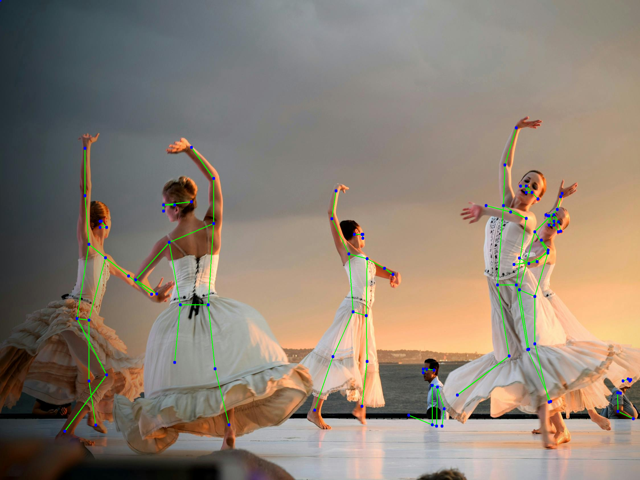

In [37]:
Image.fromarray(scene).resize([640, 480])